## Count Data - Data Science Portfolio - Maximilian Koch

**Dataset**: Bike sharing counts in Washington D.C.<br>
**Target variable**: Predicting number of shared bikes<br>
**Features**: Weather and date information<br>
**Techniques applied**: Log-linear regression, Poisson regression<br>

Log-linear and poisson regression assumes that the logarithm of a variable can be explained as a linear combination of features, thus:
$\ln(E[y_i]) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + ... + \beta_p x_{ip} = x_i^T \beta$.
However, log-linear regression uses OLS to minimize the coefficients, which assumes normality, while Poisson regression assumes
a Poisson distribution and uses Maximum Likelihood Estimation.


To demonstrate the benefits of Poisson regression over log-linear regression for count data, I used a bike sharing dataset, which measures the count of bikes used by a bike sharing system in Washington D. C. and includes seasonal and weather patterns.

Source: 
Fanaee-T, H. (2013). Bike Sharing [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5W894. /
Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

### Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('datasets/count_dataset.csv')

Let's see if the data needs any transformation!

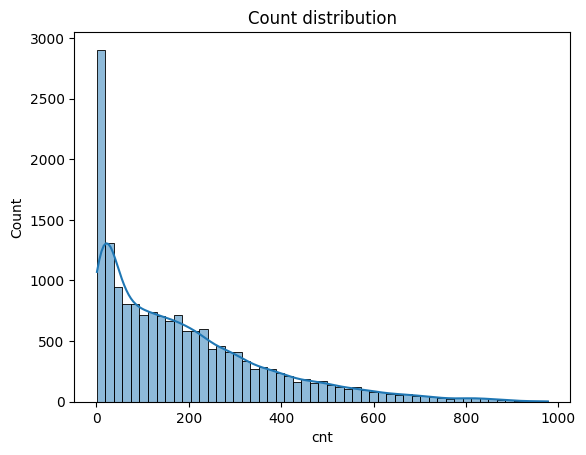

In [3]:
sns.histplot(custom_df['cnt'], kde=True)
plt.title('Count distribution')
plt.show()

This distribution is heavily skewed to the right and not normally distribution, thus applying a log transformation for linear regression makes sense.

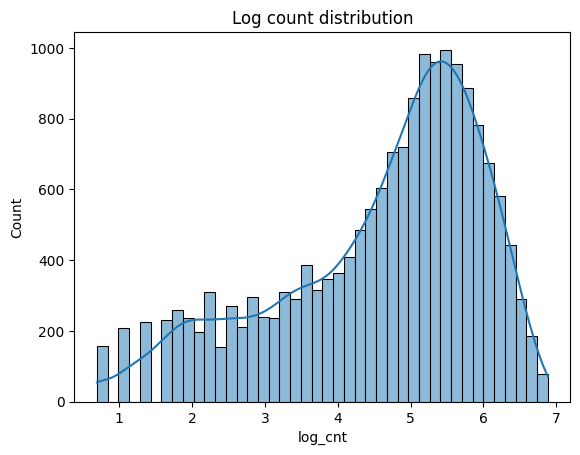

In [6]:
custom_df['log_cnt'] = np.log(custom_df['cnt'] + 1)

sns.histplot(custom_df['log_cnt'], kde=True)
plt.title('Log count distribution')
plt.show()

Still not normal, but much better than before.

### Log-linear regression

In [7]:
X = custom_df[['temp','hum','windspeed','hr','workingday','holiday','yr']]

model = sm.OLS(custom_df['log_cnt'],X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                log_cnt   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                          4.102e+04
Date:                Thu, 03 Apr 2025   Prob (F-statistic):                        0.00
Time:                        10:11:49   Log-Likelihood:                         -26997.
No. Observations:               17379   AIC:                                  5.401e+04
Df Residuals:                   17372   BIC:                                  5.406e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

All the features are significant (with holiday just below the p < 0.05 threshold) and r² is quite high.

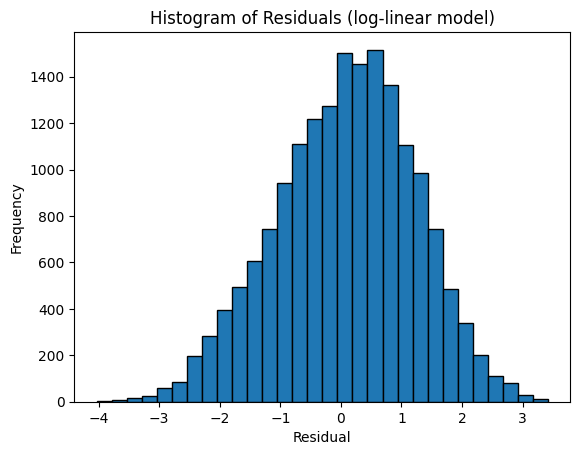

In [8]:
plt.hist(model.resid, bins=30, edgecolor='k')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (log-linear model)')
plt.show()

The residuals are a bit skewed, but resemble a normal distribution.

Coefficient significance:

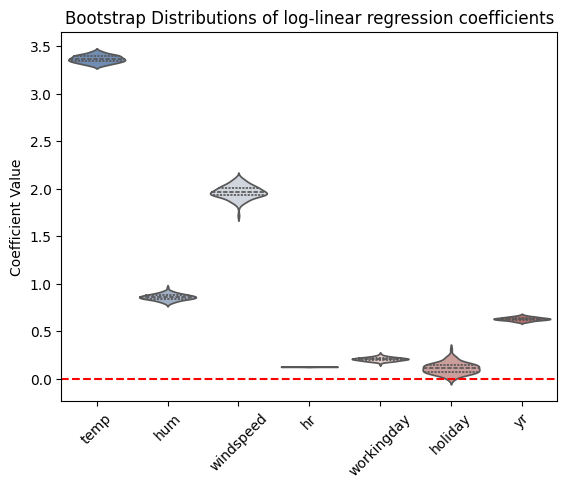

In [9]:
simulated_betas = multivariate_normal.rvs(mean=model.params,
cov=model.cov_params(),size=100)
simulated_df = pd.DataFrame(simulated_betas, columns=model.params.index)

sns.violinplot(data=simulated_df, inner="quartile", palette="vlag")
plt.axhline(0, color="red", linestyle="--") #zero effect line
plt.xticks(rotation=45)
plt.title("Bootstrap Distributions of log-linear regression coefficients")
plt.ylabel("Coefficient Value")
plt.show()


Besides the holiday variable, all others are clearly significant.

RMSE: 210.78084790048885
Bias: -17.930732463088155
Correlation: 0.4206326386876791


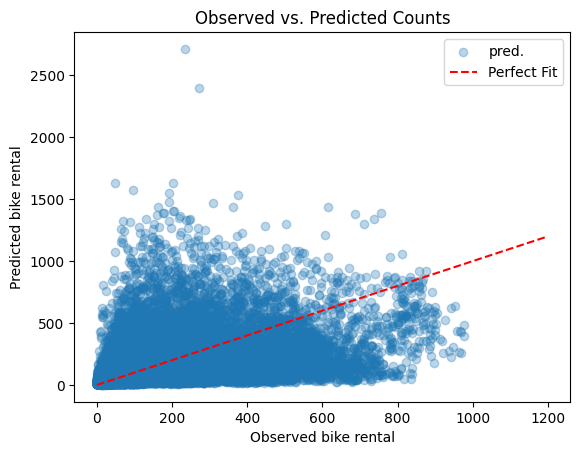

In [10]:
predictions = np.exp(model.predict(X))

rmse = np.sqrt(mean_squared_error(custom_df['cnt'], predictions))
bias = np.mean(predictions - custom_df['cnt'])
correlation = np.corrcoef(predictions, custom_df['cnt'])[0,1]

print('RMSE:',rmse)
print('Bias:',bias)
print('Correlation:',correlation)

plt.scatter(custom_df['cnt'], predictions, alpha=0.3, label='pred.')
plt.plot([0, 1200], [0, 1200], 'r--', label="Perfect Fit") 
plt.xlabel('Observed bike rental')
plt.ylabel('Predicted bike rental')
plt.title('Observed vs. Predicted Counts')
plt.legend()
plt.show()

### Poisson regression

In [11]:
X = custom_df[['temp', 'hum', 'windspeed', 'hr', 'workingday', 'holiday', 'yr']]
X = sm.add_constant(X)

poisson_model = sm.GLM(custom_df['cnt'],X,family=sm.families.Poisson()).fit()
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                17379
Model:                            GLM   Df Residuals:                    17371
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.3060e+05
Date:                Thu, 03 Apr 2025   Deviance:                   1.7503e+06
Time:                        10:12:10   Pearson chi2:                 1.96e+06
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0210      0.004   1131.998      0.0

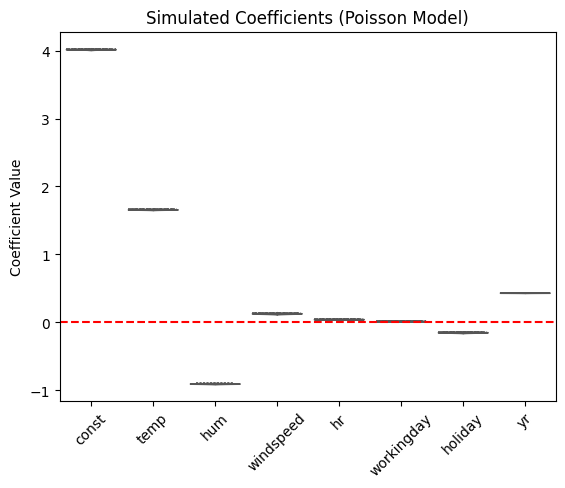

In [12]:
simulated_betas = multivariate_normal.rvs(mean=poisson_model.params,cov=poisson_model.cov_params(),size=1000)
simulated_df = pd.DataFrame(simulated_betas, columns=poisson_model.params.index)

sns.violinplot(data=simulated_df, inner="quartile", palette="vlag")
plt.axhline(0, color="red", linestyle="--")
plt.xticks(rotation=45)
plt.title("Simulated Coefficients (Poisson Model)")
plt.ylabel("Coefficient Value")
plt.show()

Interestingly, some coefficients are negative that were positive for the log-linear regression (holiday and humidity). The range of the simulated coefficients is much smaller than the range of linear model. Thus the predictions are more stable.

Observed vs predicted

RMSE: 145.34058862841874
Bias: -5.42064912881293e-12
Correlation: 0.6001007521773261


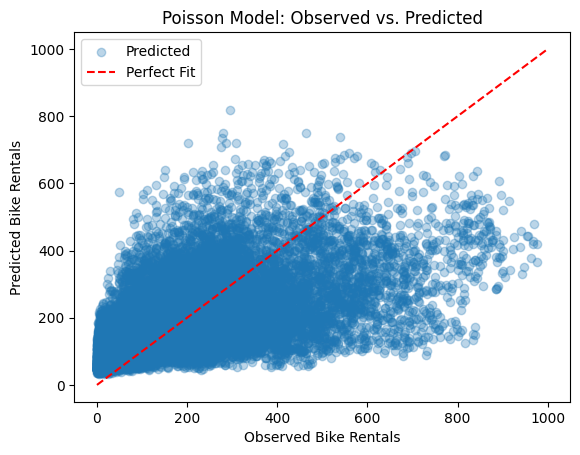

In [13]:

predictions = poisson_model.predict(X)

rmse = np.sqrt(mean_squared_error(custom_df['cnt'], predictions))
bias = np.mean(predictions - custom_df['cnt'])
correlation = np.corrcoef(predictions, custom_df['cnt'])[0,1]

print('RMSE:',rmse)
print('Bias:',bias)
print('Correlation:',correlation)

plt.scatter(custom_df['cnt'], predictions, alpha=0.3, label='Predicted')
plt.plot([0, 1000], [0, 1000], 'r--', label="Perfect Fit")
plt.xlabel('Observed Bike Rentals')
plt.ylabel('Predicted Bike Rentals')
plt.title('Poisson Model: Observed vs. Predicted')
plt.legend()
plt.show()

There is a lower RMSE, almost no bias and a higher correlation between the observed and fitted.
Visually, the data seems more equally distributed / less bias.
Thus, the Poisson regression performs much better than the log-linear model.